# Análise Exploratória de Séries Temporais

In [4]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from src.analise_exploratoria import (
    visualizar_grafico,
    visualizar_grafico_grid,
    extrair_periodicidade,
    remover_tendencia,
    plotar_tendencia,
    plotar_periodicidade,
)

In [8]:
# Carramentos do arquivo de vendas
df_sales = pd.read_csv("../data/raw/sales.csv")

In [9]:
# Exibindo os primeiros registros do dataframe
df_sales.head()

,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-30,TX_1,FOODS,3844.97
2,2011-01-31,TX_1,FOODS,2888.03
3,2011-02-01,TX_1,FOODS,3631.28
4,2011-02-02,TX_1,FOODS,3072.18


In [10]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      58230 non-null  object 
 1   store_id  58230 non-null  object 
 2   cat_id    58230 non-null  object 
 3   sales     58230 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


In [11]:
# AJustando o tipo de dado da coluna date
df_sales["date"] = pd.to_datetime(df_sales["date"])

# Alterando a index do dataframe para a coluna date
df_sales = df_sales.set_index("date")

df_sales.head(5)

,store_id,cat_id,sales
date,,,
2011-01-29,TX_1,FOODS,3950.35
2011-01-30,TX_1,FOODS,3844.97
2011-01-31,TX_1,FOODS,2888.03
2011-02-01,TX_1,FOODS,3631.28
2011-02-02,TX_1,FOODS,3072.18


In [12]:
print(df_sales.index)

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16',
               '2016-05-17', '2016-05-18', '2016-05-19', '2016-05-20',
               '2016-05-21', '2016-05-22'],
              dtype='datetime64[ns]', name='date', length=58230, freq=None)


In [13]:
# contagem única de store_id e cat_id
print(
  f"Existem {df_sales.store_id.nunique()} lojas e {df_sales.cat_id.nunique()} categorias."
)

Existem 10 lojas e 3 categorias.


In [14]:
# Valores únicos de store_id e cat_id
print(df_sales.store_id.unique())
print(df_sales.cat_id.unique())

['TX_1' 'TX_2' 'TX_3' 'CA_1' 'CA_2' 'CA_3' 'CA_4' 'WI_1' 'WI_2' 'WI_3']
['FOODS' 'HOBBIES' 'HOUSEHOLD']


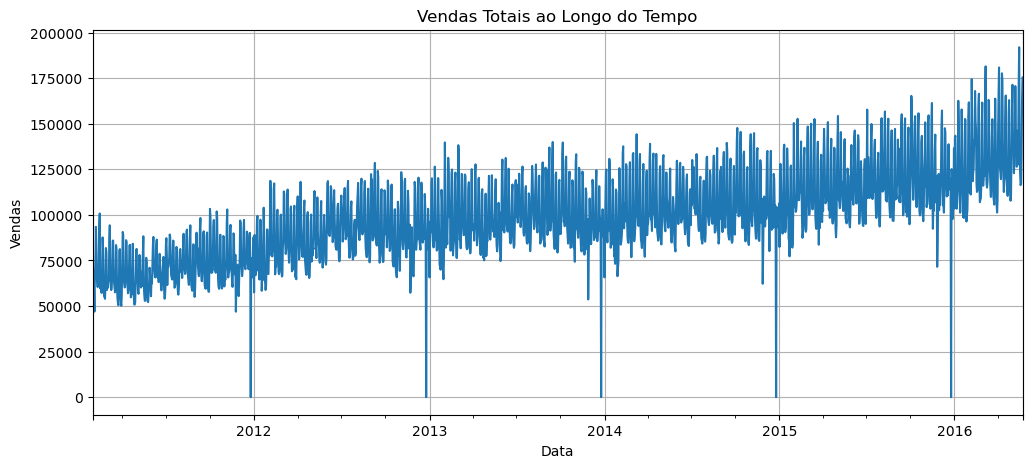

In [15]:
# Agregando as vendas por data
df_sales_agg = df_sales.groupby("date")["sales"].sum()

# Plotando a série temporal agregada
plt.figure(figsize=(12, 5))
df_sales_agg.plot(title="Vendas Totais ao Longo do Tempo", ylabel="Vendas", xlabel="Data")
plt.grid()
plt.show()

O gráfico revela um padrão sazonal claro e uma tendência de crescimento ao longo do tempo, mas um ponto de atenção são as quedas abruptas nas vendas em determinados momentos. Essas quedas podem indicar outliers que precisam ser investigados. Visto que se trata de um dataset de varejo, algumas possíveis explicações incluem falhas na coleta de dados, fechamento temporário de lojas ou eventos externos impactando as vendas.


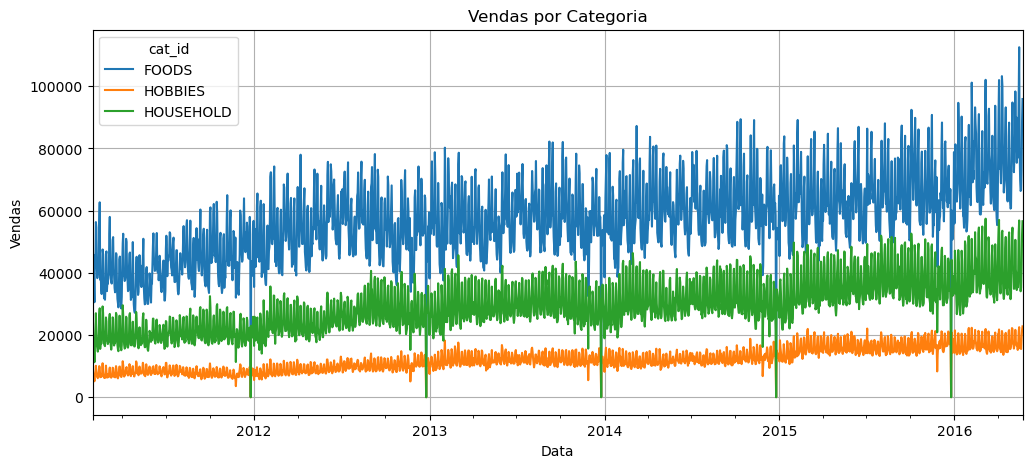

In [16]:
# Agregando as vendas por data e categoria
df_sales_cat = df_sales.groupby(["date", "cat_id"])["sales"].sum().unstack()

# Plotando
df_sales_cat.plot(figsize=(12, 5), title="Vendas por Categoria", ylabel="Vendas", xlabel="Data")
plt.grid()
plt.show()

O gráfico evidencia um crescimento consistente das vendas em todas as categorias (FOODS, HOUSEHOLD, HOBBIES), com FOODS liderando em volume. A presença de padrões sazonais sugere que eventos recorrentes influenciam as vendas.

No entanto, quedas abruptas em diversos momentos indicam outliers que podem estar relacionados a falhas nos dados, fechamento de lojas ou eventos externos. Para validar essa hipótese, é necessário investigar as datas afetadas, analisar variações por loja e aplicar métodos estatísticos para detecção de anomalias, o que faremos posteriormente na fase de limpeza dos dados.

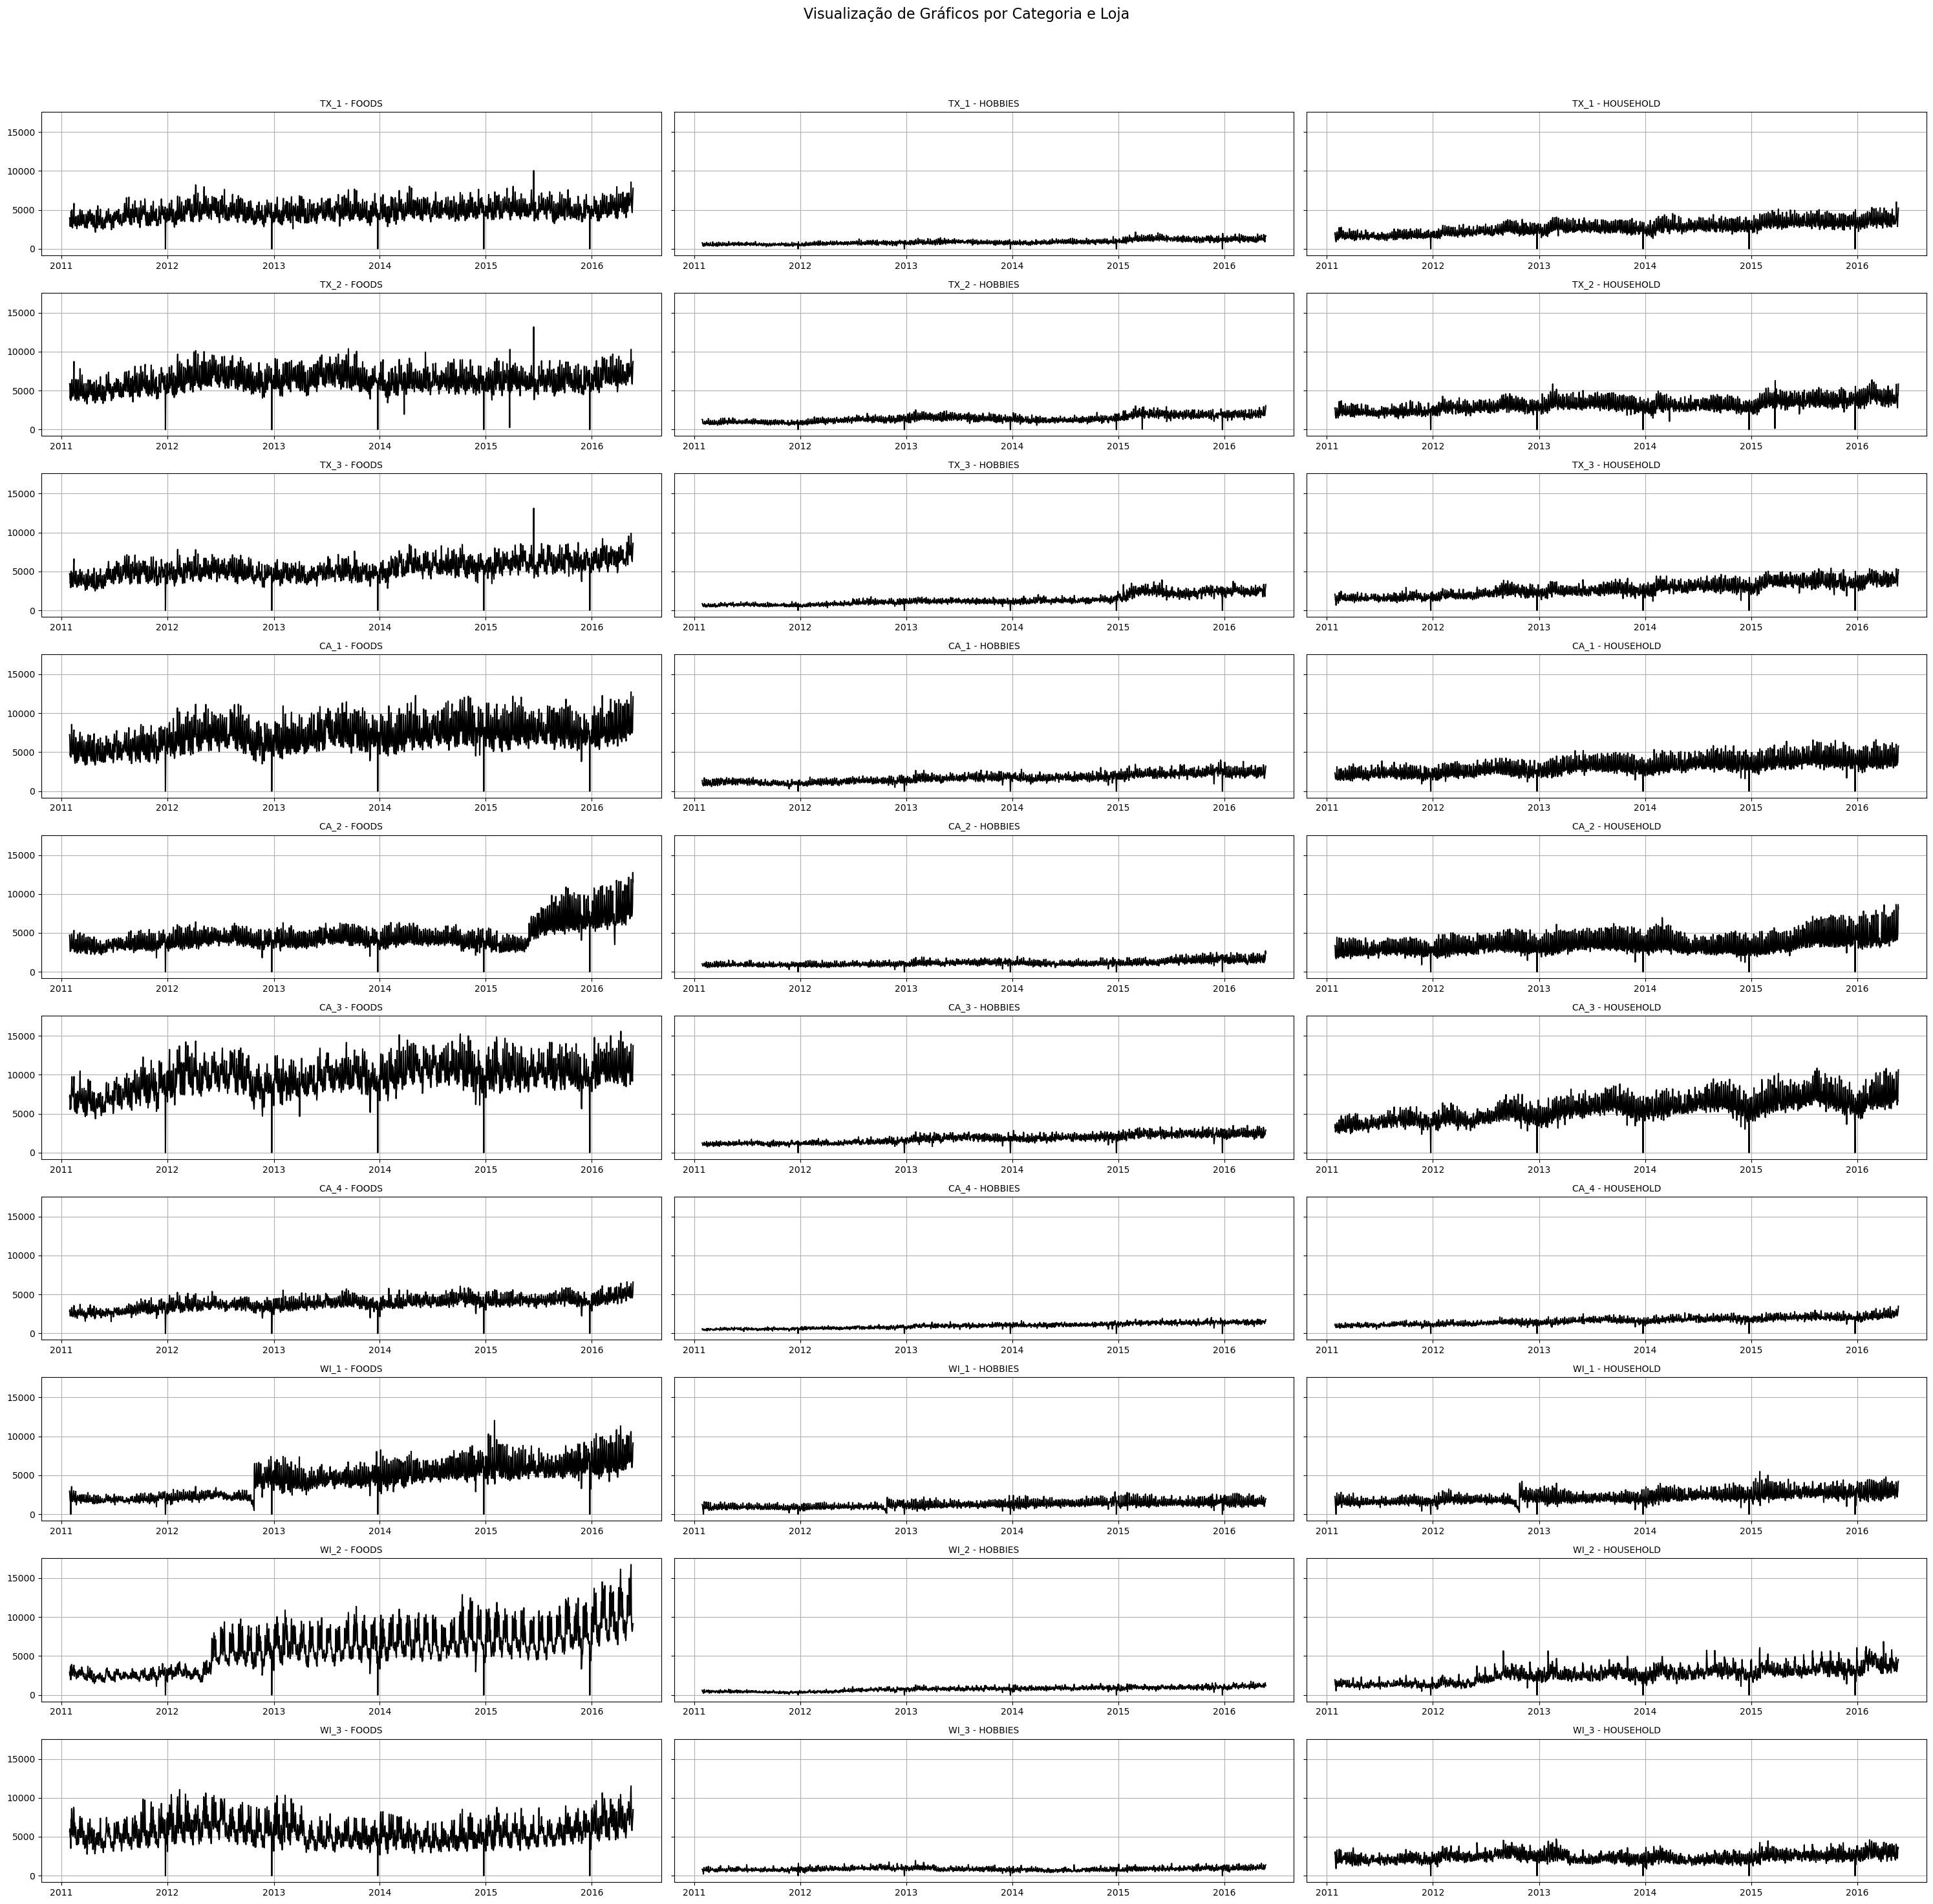

In [17]:
lojas = df_sales.store_id.unique()
categorias = df_sales.cat_id.unique()

visualizar_grafico_grid(df_sales, lojas, categorias)

Como observado nos gráficos, algumas lojas e categorias, como **CA_2 na categoria FOODS, WI_1 na categoria FOODS, WI_2 na categoria FOODS, WI_1 e WI_2 na categoria HOUSEHOLD**, apresentaram mudanças estruturais significativas, tornando os dados anteriores pouco representativos do comportamento atual. Dessa forma, a exclusão dos dados anteriores às quebras de tendência ajudará a manter a **coerência analítica** das séries temporais, evitando que padrões obsoletos comprometam as análises. **Manter essas informações poderia enviesar previsões e dificultar a identificação de padrões reais.**

Além disso, a remoção dos períodos anteriores garantirá **maior estabilidade nos modelos**, evitando interferências de regimes estatísticos distintos. Em alguns casos, as quebras bruscas refletem mudanças operacionais, como **novas estratégias comerciais ou alterações na demanda**, que devem ser analisadas separadamente. Para evitar distorções, a abordagem adotada priorizou a modelagem apenas a partir do **novo regime da série**, garantindo previsões **mais confiáveis e alinhadas com a realidade do negócio.**

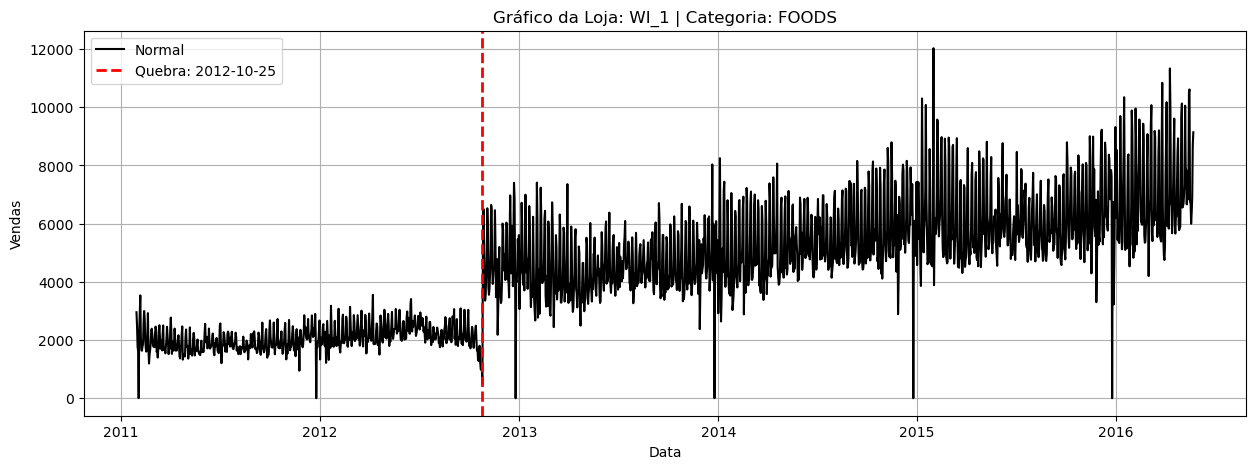

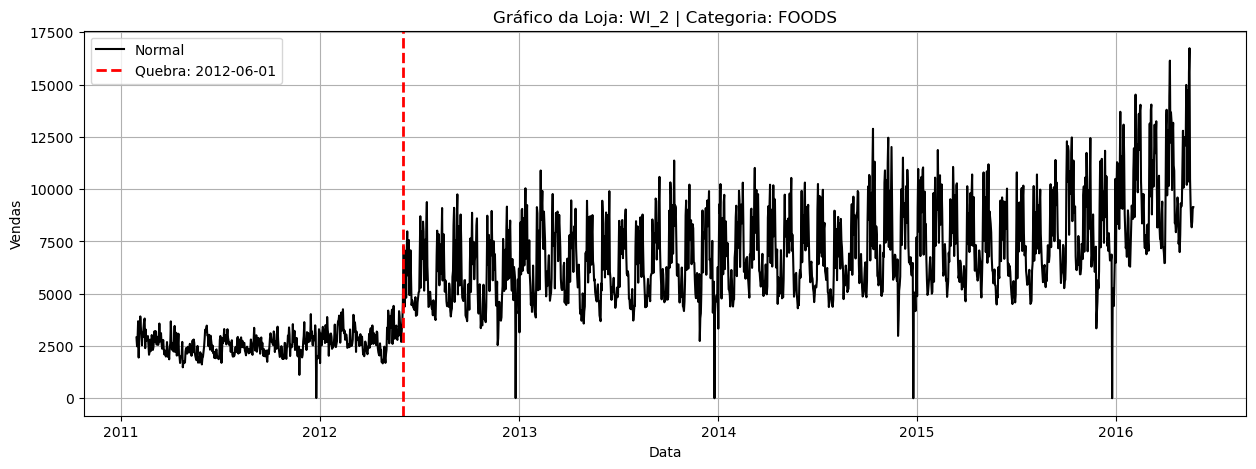

In [18]:
visualizar_grafico(df_sales, "WI_1", "FOODS", "2012-10-25")
visualizar_grafico(df_sales, "WI_2", "FOODS", "2012-06-01")

In [19]:
sales_df_clean = df_sales.copy()
sales_df_clean["series_id"] = sales_df_clean["store_id"] + "_" + sales_df_clean["cat_id"]

# definir indicador para marcar pontos de dados a serem descartados
sales_df_clean["drop_ind"] = (
    ((sales_df_clean.series_id == "CA_2_FOODS") & (sales_df_clean.index < "2015-06-01"))
    | ((sales_df_clean.series_id == "WI_1_FOODS") & (sales_df_clean.index < "2012-10-25"))
    | ((sales_df_clean.series_id == "WI_2_FOODS") & (sales_df_clean.index < "2012-06-01"))
    | ((sales_df_clean.series_id == "WI_1_HOUSEHOLD") & (sales_df_clean.index < "2012-11-01"))
    | ((sales_df_clean.series_id == "WI_2_HOUSEHOLD") & (sales_df_clean.index < "2012-06-01"))
)

# descartar os pontos de dados identificados como dados anteriores às quebras de tendência
sales_df_clean = sales_df_clean.loc[sales_df_clean.drop_ind == False]
sales_df_clean.drop(columns=["drop_ind"], inplace=True)
sales_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54391 entries, 2011-01-29 to 2016-05-22
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   store_id   54391 non-null  object 
 1   cat_id     54391 non-null  object 
 2   sales      54391 non-null  float64
 3   series_id  54391 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


In [20]:
# Salvando o dataframe limpo 
sales_df_clean.to_parquet("../data/interim/sales_exploratory_cleaned.parquet")

Agora que limpamos e salvamos os dados de vendas, podemos analisá-los novamente em mais detalhes. Especificamente, vamos explorar e visualizar as vendas no varejo por dia da semana, mês e ano, identificando padrões de tendência e sazonalidade ao longo do tempo.

Text(0.5, 0, 'month')

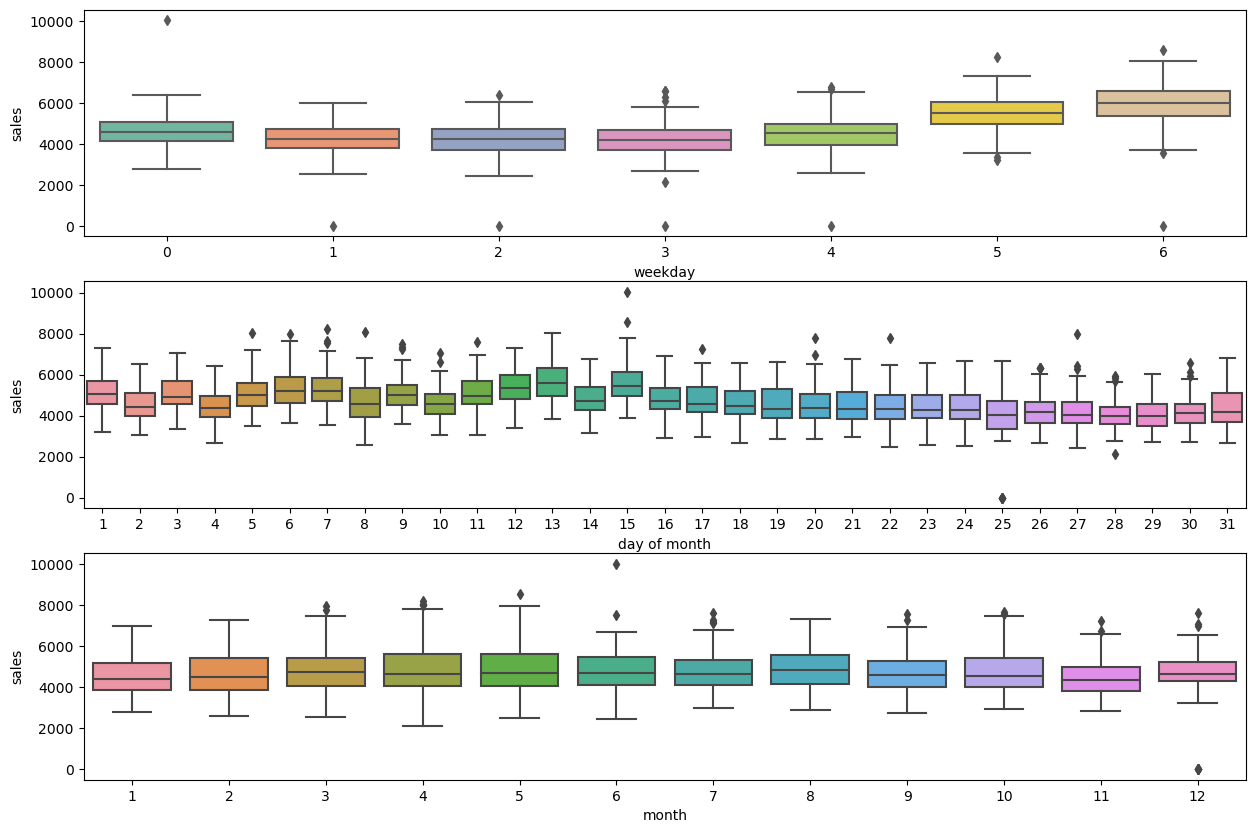

In [21]:
# filter for a time series
store = "TX_1"
category = "FOODS"
sales_series_df_plot = sales_df_clean.loc[
    (sales_df_clean.store_id == store) & (sales_df_clean.cat_id == category)
]

sns.set_palette("Set2")

# box plots by weekday, day of month, and month
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
sns.boxplot(x=sales_series_df_plot.index.weekday, y=sales_series_df_plot.sales, ax=ax[0])
sns.boxplot(x=sales_series_df_plot.index.day, y=sales_series_df_plot.sales, ax=ax[1])
sns.boxplot(x=sales_series_df_plot.index.month, y=sales_series_df_plot.sales, ax=ax[2])

ax[0].set_xlabel("weekday")
ax[1].set_xlabel("day of month")
ax[2].set_xlabel("month")

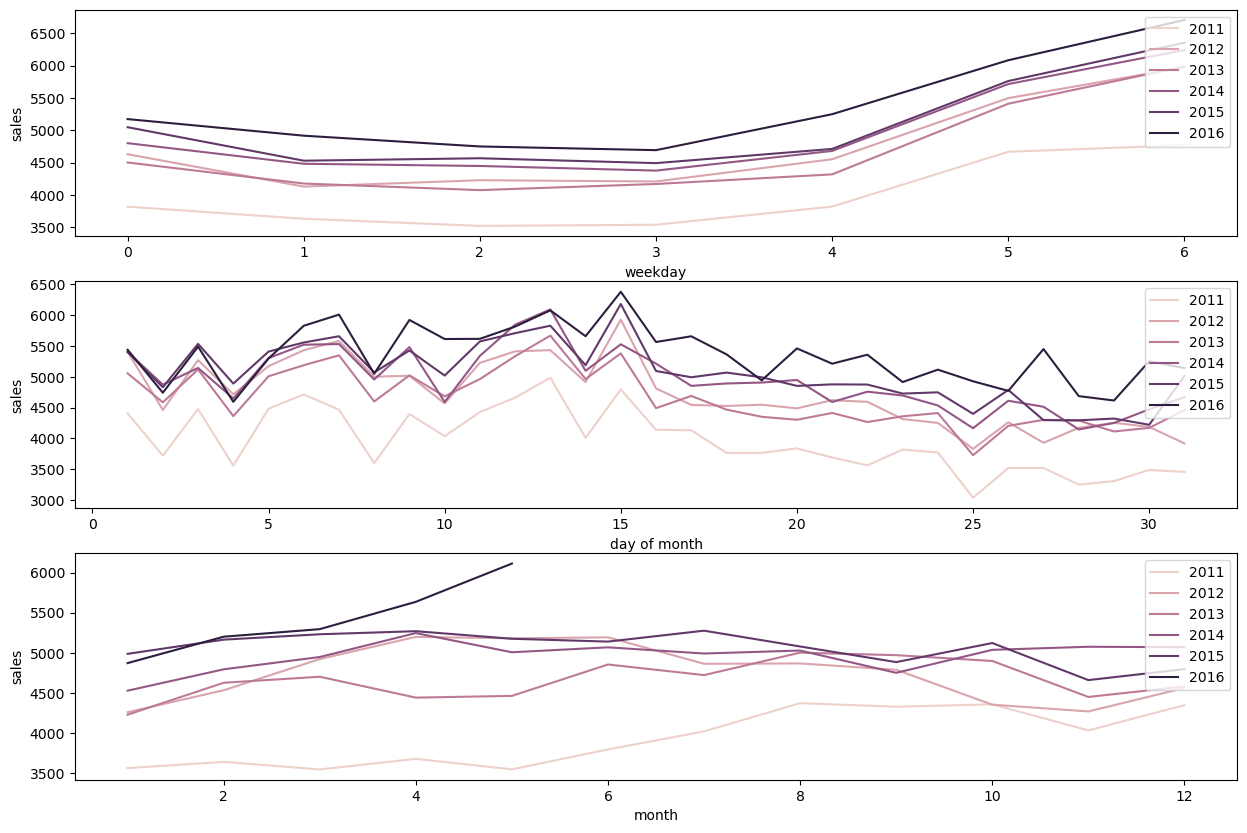

In [22]:
# line charts by weekday, day of month, and month, group by year
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

sns.lineplot(
    x=sales_series_df_plot.index.weekday,
    y=sales_series_df_plot.sales,
    hue=sales_series_df_plot.index.year,
    ax=ax[0],
    errorbar=None,
)
sns.lineplot(
    x=sales_series_df_plot.index.day,
    y=sales_series_df_plot.sales,
    hue=sales_series_df_plot.index.year,
    ax=ax[1],
    errorbar=None,
)
sns.lineplot(
    x=sales_series_df_plot.index.month,
    y=sales_series_df_plot.sales,
    hue=sales_series_df_plot.index.year,
    ax=ax[2],
    errorbar=None,
)

ax[0].set_xlabel("weekday")
ax[1].set_xlabel("day of month")
ax[2].set_xlabel("month")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
ax[2].legend(loc="upper right")


A partir dos gráficos, conseguimos identificar um padrão claro de dias da semana e sazonalidade mensal:

- As vendas tendem a ser mais altas às sextas-feiras e nos finais de semana.
- Observamos um pico no meio do mês, seguido por uma tendência de queda no restante do período.
- Não há uma sazonalidade anual evidente.

Além da análise visual, existe uma forma mais objetiva de determinar a sazonalidade? É exatamente isso que vamos investigar na próxima seção. 

### Sazonalidade

Para determinar a sazonalidade de forma mais objetiva, utilizamos um periodograma, uma ferramenta poderosa na análise de séries temporais.

A ideia central do periodograma é decompor a série temporal em ondas de diferentes frequências e amplitudes, identificando padrões de repetição ao longo do tempo. Ele destaca as frequências dominantes que melhor descrevem as oscilações da série, permitindo detectar padrões sazonais com maior precisão.

Conforme descrito no material da Penn State University, o periodograma atua como um espectro de potência da série, capturando ciclos recorrentes que podem não ser facilmente perceptíveis apenas com visualizações tradicionais.

Dessa forma, se houver um padrão sazonal recorrente, o periodograma conseguirá evidenciá-lo, fornecendo uma base matemática para validar a presença de sazonalidade na série temporal

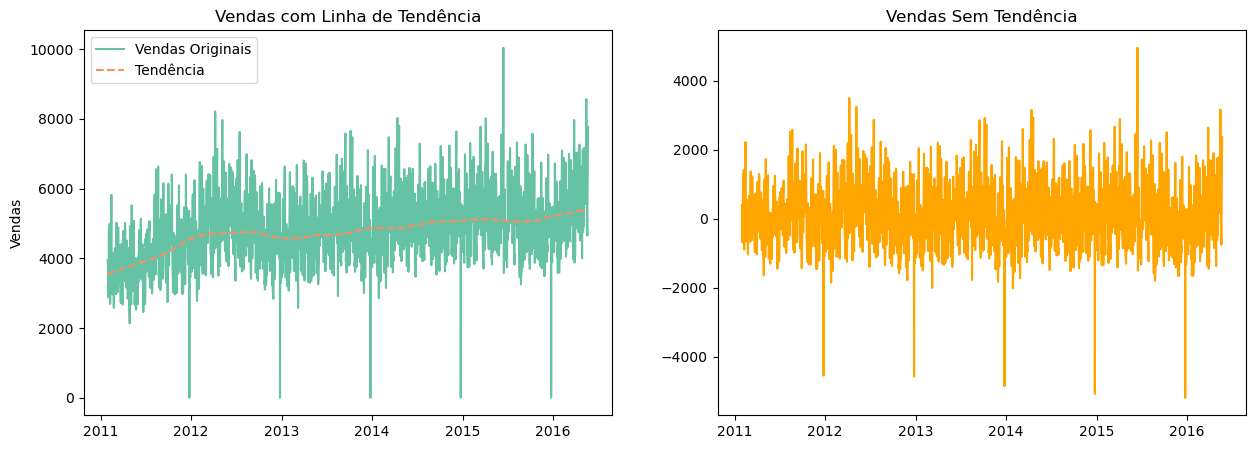

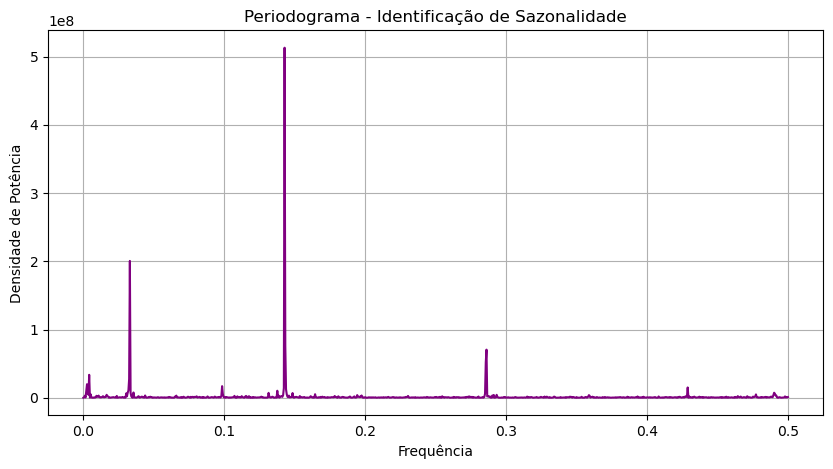

In [23]:
loja = "TX_1"
categoria = "FOODS"

data_detrended, data_trend, df_series = remover_tendencia(df_sales, loja, categoria)

# plot time series original and detrended sales
plotar_tendencia(df_series, data_trend, data_detrended)

# plot periodogram
plotar_periodicidade(data_detrended)

Analisando o periodograma, podemos identificar 2 a 3 valores de frequência com alta densidade espectral de potência, indicando possíveis padrões sazonais. Em particular, um dos picos se destaca significativamente em relação aos demais, sugerindo uma forte sazonalidade dominante. Com base em nossa análise anterior dos gráficos de vendas, podemos inferir que esse pico provavelmente representa a sazonalidade semanal, onde as vendas seguem um padrão recorrente ao longo dos dias da semana. Além disso, outros picos menores podem indicar efeitos sazonais adicionais, como padrões mensais ou até mesmo influências externas no comportamento de vendas.

In [24]:
extrair_periodicidade(data_detrended, calcular_periodo=True)

(     intervalo  densidade_espectral
 276   7.007220         5.131260e+08
 63   30.328125         2.005462e+08
 277   6.982014         7.616442e+07,
 7.007220216606498)

Os resultados do periodograma indicam a presença de padrões sazonais bem definidos. O principal ciclo identificado tem um intervalo de aproximadamente 7 dias, reforçando um comportamento semanal na série, algo esperado para dados de vendas. Além disso, há um segundo pico significativo próximo de 30 dias, sugerindo um possível padrão mensal, já o intervalo igual a 6.982014 é muito próximo ao primeiro, o que pode ser um artefato numérico da análise. Esses achados estão alinhados com a análise visual anterior, confirmando que a série apresenta sazonalidade estruturada, principalmente em nível semanal.

In [25]:
lista_periodogramas = []

for loja in df_sales.store_id.unique():
    for categoria in df_sales.cat_id.unique():
        dados_sem_tendencia, dados_tendencia, df_serie = remover_tendencia(df_sales, loja, categoria)
        df_periodicidade = extrair_periodicidade(dados_sem_tendencia)
        lista_periodogramas.append(df_periodicidade)

df_periodogramas = pd.concat(lista_periodogramas)
df_periodogramas["intervalo"] = df_periodogramas["intervalo"].round(0).astype(int)
df_periodogramas.sort_values(by="densidade_espectral", ascending=False, inplace=True)
df_periodogramas.intervalo.value_counts()

intervalo
7      56
30     11
3      11
323     4
4       3
31      2
388     1
277     1
243     1
Name: count, dtype: int64

Como os valores de frequência provavelmente não fazem sentido para nós, podemos invertê-los para obter os valores do intervalo de tempo. Ao filtrar os 3 principais valores de frequência para cada série temporal e resumir as contagens dos intervalos de tempo, somos capazes de identificar claramente as sazonalidades semanal (intervalo de tempo 7) e mensal (intervalo de tempo 30). Podemos ignorar o restante dos intervalos de tempo que não ocorrem com tanta frequência. Curiosamente, o intervalo de tempo 3 ocorre com frequência e talvez possamos interpretá-lo como sazonalidade semestral.